In [57]:
#import tools and libraries
from collections import defaultdict
import requests
import lxml.etree as ET
from sklearn import datasets, neighbors, metrics
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [58]:
%matplotlib inline

In [59]:
#This was going to be used to convert my data from unicode to ascii.  I found out that this wasn't necessary so I could 
#probably delete this line.
def cleanStr(col):
    return col.encode("ascii", "ignore")

In [60]:
#bring in original datasets
df = pd.read_excel("NBA_excel.xlsx", converters={"Team": cleanStr})

In [6]:
#bring in stat data which houses 3 point shot attempts per season, FT per season etc..
#Assign a unique key to each line in the stat DB
statdf = pd.read_excel("NBA-Stats.xls")
statdf['key'] = statdf['Year'].apply(lambda x: str(x))
statdf['key'] = (statdf['key'] + statdf['Team'])
statdf['key'] = statdf['key'].apply(lambda x: x.replace(" ",""))
statdf.head(5)

,Team,Year,Playoffs,G,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PTS/G,key
0,Atlanta Hawks,1979,Yes,82,19780,3261,7027,0.464,13,75,...,2406,3775,1913,782,539,1495,2293,8573,104.5,1979AtlantaHawks
1,Atlanta Hawks,1980,No,82,19930,3291,6866,0.479,10,82,...,2224,3425,1846,749,469,1605,2276,8604,104.9,1980AtlantaHawks
2,Atlanta Hawks,1981,Yes,82,19880,3210,6776,0.474,28,128,...,2368,3503,1815,608,485,1343,2268,8281,101.0,1981AtlantaHawks
3,Atlanta Hawks,1982,Yes,82,19780,3352,7146,0.469,45,188,...,2433,3572,1945,573,665,1424,2022,8335,101.6,1982AtlantaHawks
4,Atlanta Hawks,1983,Yes,82,19855,3230,6809,0.474,23,106,...,2232,3344,1827,626,558,1329,2091,8321,101.5,1983AtlantaHawks


In [7]:
#review how many rows the stat DB has
statdf.describe()

,Year,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PTS/G
count,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,...,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000,954.000000
mean,1996.974843,79.448637,19204.675052,3080.919287,6640.143606,0.462877,329.180294,943.993711,0.328597,2751.738994,...,1017.245283,2360.721174,3377.966457,1838.398323,645.302935,406.072327,1253.672956,1803.617400,8068.859539,101.392453
std,9.929415,8.332290,2012.318517,457.793793,832.446231,0.022214,196.569405,516.110470,0.049800,561.499579,...,192.793728,266.259130,393.788560,308.491116,114.333763,91.163368,206.485547,280.277612,1088.047423,7.107396
min,1979.000000,46.000000,11040.000000,1539.000000,3561.000000,0.401000,10.000000,75.000000,0.104000,1249.000000,...,345.000000,1293.000000,1734.000000,782.000000,270.000000,161.000000,616.000000,837.000000,4095.000000,81.900000
25%,1989.000000,82.000000,19755.000000,2923.250000,6473.500000,0.447000,152.000000,474.750000,0.313000,2446.250000,...,909.000000,2313.000000,3325.000000,1691.000000,581.000000,349.000000,1157.250000,1691.500000,7811.250000,96.200000
50%,1997.000000,82.000000,19805.000000,3093.500000,6760.500000,0.461000,335.500000,974.500000,0.343000,2639.000000,...,1030.000000,2419.000000,3456.500000,1851.000000,647.500000,400.000000,1256.500000,1839.000000,8220.500000,100.600000
75%,2006.000000,82.000000,19855.000000,3385.750000,7119.000000,0.478000,483.000000,1356.750000,0.362000,3244.500000,...,1145.000000,2507.000000,3593.000000,2051.250000,718.750000,461.000000,1374.750000,1978.750000,8729.000000,106.500000
max,2013.000000,82.000000,20080.000000,3980.000000,8868.000000,0.545000,891.000000,2371.000000,0.428000,3954.000000,...,1520.000000,2801.000000,4057.000000,2575.000000,1053.000000,716.000000,1873.000000,2432.000000,10371.000000,126.500000


In [61]:
#Assign a unique key to each line in the original DB
df['key'] = df['Year'].apply(lambda x: str(x))
df['key'] = (df['key'] + df['Team'])
df['key'] = df['key'].apply(lambda x: x.replace(" ",""))
df.head()

,Year,Team,Home Wins,Away Wins,WinDif,HomePCT,AwayPCT,TotalPCT,PCTdif,Attendance,Capacity,%Cap,key
0,1968,Atlanta Hawks,28,18,10,0.7000,0.4615,0.585366,0.2385,4474.0,8600.0,0.520233,1968AtlantaHawks
1,1969,Atlanta Hawks,25,18,7,0.6579,0.5294,0.585366,0.1285,5210.0,8600.0,0.605814,1969AtlantaHawks
2,1970,Atlanta Hawks,21,14,7,0.5122,0.3500,0.439024,0.1622,5998.0,8600.0,0.697442,1970AtlantaHawks
3,1971,Atlanta Hawks,22,13,9,0.5366,0.3333,0.439024,0.2033,5629.0,8600.0,0.654535,1971AtlantaHawks
4,1972,Atlanta Hawks,28,17,11,0.6829,0.4250,0.560976,0.2579,7434.0,16378.0,0.453902,1972AtlantaHawks


In [62]:
#create city attribute by pulling the first word from Team attribute.  All of the two word cities are concatenated.
#Note - the space in the Team attribute was messed up so I replaced it in excel.  Sorry, fixing it in here was taking too long.
df['City'] = df['Team'].apply(lambda x: x.split(" ")[0])

In [63]:
df.head()

,Year,Team,Home Wins,Away Wins,WinDif,HomePCT,AwayPCT,TotalPCT,PCTdif,Attendance,Capacity,%Cap,key,City
0,1968,Atlanta Hawks,28,18,10,0.7000,0.4615,0.585366,0.2385,4474.0,8600.0,0.520233,1968AtlantaHawks,Atlanta
1,1969,Atlanta Hawks,25,18,7,0.6579,0.5294,0.585366,0.1285,5210.0,8600.0,0.605814,1969AtlantaHawks,Atlanta
2,1970,Atlanta Hawks,21,14,7,0.5122,0.3500,0.439024,0.1622,5998.0,8600.0,0.697442,1970AtlantaHawks,Atlanta
3,1971,Atlanta Hawks,22,13,9,0.5366,0.3333,0.439024,0.2033,5629.0,8600.0,0.654535,1971AtlantaHawks,Atlanta
4,1972,Atlanta Hawks,28,17,11,0.6829,0.4250,0.560976,0.2579,7434.0,16378.0,0.453902,1972AtlantaHawks,Atlanta


In [64]:
#Update cities for teams where the city is not in the team name
#Tri-Cities = Chicago
#Minnesota = Minneapolis
#Indiana = Indianapolis
#Utah = Salt Lake City
#Capitol = WashingtonDC
#Washington = WashingtonDC
#KansasCity-Omaha = KansasCity
#GoldenState = Oakland


def CTchange(arg):                    
    if arg == 'Tri-Cities':
        return 'Chicago'
    elif arg == 'Minnesota':
        return 'Minneapolis'
    elif arg == 'Indiana':
        return 'Indianapolis'
    elif arg == 'Utah':
        return 'SaltLakeCity'
    elif arg == 'Capitol':
        return 'WashingtonDC'
    elif arg == 'Washington':
        return 'WashingtonDC'
    elif arg == 'KansasCity-Omaha':
        return 'KansasCity'
    elif arg == 'GoldenState':
        return 'Oakland'
    else:
        return arg
    
df['City'] = df['City'].apply(lambda x: CTchange(x))

In [65]:
#review city options
Cities = list(df['City'].values)
CityOps = set(Cities)
print CityOps

set(['Rochester', 'Chicago', 'NewYork', 'Philadelphia', 'Denver', 'Vancouver', 'Indianapolis', 'Phoenix', 'OklahomaCity', 'Sacramento', 'Dallas', 'WashingtonDC', 'SanAntonio', 'SaltLakeCity', 'Atlanta', 'Memphis', 'Syracuse', 'Toronto', 'LosAngeles', 'NewOrleans', 'Houston', 'Miami', 'Orlando', 'Detroit', 'St.Louis', 'SanFrancisco', 'Buffalo', 'Baltimore', 'Charlotte', 'KansasCity', 'Seattle', 'Cincinnati', 'SanDiego', 'NewJersey', 'Boston', 'Minneapolis', 'Cleveland', 'Milwaukee', 'Portland', 'Oakland'])


In [14]:
#use the Wolfram|Alpha API to get the time zone of each value in 'City'
def ask_wolfram(query):
    
    #We want to create a variable called "success" that changes if we get a result from the API
    success = False
    
    #Keep running the script until success is True
    while success == False:
        
        #Send the API request with our string and save the result as a variable called content
        content= requests.get("http://api.wolframalpha.com/v2/query?input="+query+"&appid=U6GJV5-E3P6AWJP78")    
        
        #get the XML content returned from the API and encode it in utf-8, which can handle special characters better
        content_string = content.text.encode('utf-8')
        
        #pass the XML to our XML parser
        doc = ET.fromstring(str(content_string))
        
        #find our results in the XML, which are 
        #save those results to the answer variable
        answer = doc.find('./pod[@title="Result"]/subpod/plaintext')
        
        #If we got nothing from the API, then the answer variable is a None type variable
        
        #If the answer is not None, and we get something, change success to True
        if answer!= None:  success = True
        #otherwise, we should wait for half a second before trying the request again
        else: time.sleep(.5)
    #Once we get out of the above loop, let's break out of the function by returning the answer, making sure it is encoded correctly
    return answer.text.encode('utf-8')

In [15]:
#Make an empty list to hold all of the data we collect from Wolfram Alpha. This list will hold lists that contain the City, Elevation, and Time Zone for that city.
#NOTE: This was able to run most times, but every once in a while, I got a XML Syntax Error
alldata=[]
for city in CityOps:
   
    #write the query to get the timezone
    query="Timezone of " + city
    
    #Get the elevation from Wolfram Alpha
    timezone = ask_wolfram(query)
    
    #Make sure that the returned result is a string
    timezone =str(timezone.split(" ")[0])
    
    #write the query to get the elevation of the city   
    query="Elevation of " + city
    
    #get the elevation value from Wolfram Alpha
    elevation = ask_wolfram(query)
    
    #Make sure the elevation is treated as a number, and doesn't have the feet (splitting 5280 feet at the space and getting the first element does this)
    elevation =float(elevation.split(" ")[0])
    
    
    #stock_df = stock_df.append(day_data,ignore_index=True)
    print city
    alldata.append([city,timezone,elevation])

#Make a pandas DataFrame out of the data we collected    
stock_df = pd.DataFrame(alldata,columns=["city", "timezone", "elevation" ])

print stock_df

Rochester
Chicago
NewYork
Philadelphia
Denver
Vancouver
Indianapolis
Phoenix
OklahomaCity
Sacramento
Dallas
WashingtonDC
SanAntonio
SaltLakeCity
Atlanta
Memphis
Syracuse
Toronto
LosAngeles
NewOrleans
Houston
Miami
Orlando
Detroit
St.Louis
SanFrancisco
Buffalo
Baltimore
Charlotte
KansasCity
Seattle
Cincinnati
SanDiego
NewJersey
Boston
Minneapolis
Cleveland
Milwaukee
Portland
Oakland
            city  timezone  elevation
0      Rochester   Eastern      505.0
1        Chicago   Central      587.0
2        NewYork   Eastern       33.0
3   Philadelphia   Eastern       39.0
4         Denver  Mountain     5280.0
5      Vancouver   Pacific      121.0
6   Indianapolis   Eastern      719.0
7        Phoenix  Mountain     1086.0
8   OklahomaCity   Central     1201.0
9     Sacramento   Pacific       30.0
10        Dallas   Central      420.0
11  WashingtonDC   Eastern       23.0
12    SanAntonio   Central      650.0
13  SaltLakeCity  Mountain     4262.0
14       Atlanta   Eastern     1050.0
15     

In [66]:
# Merge timezone and elevation data with original DF to make new_df
"""for row in df.iterrows():
    if row[1]['City'] == 'Atlanta':
        row[1]['Elevation'] = 1050
        row[1]['TimeZone'] = "Eastern Time"
"""
new_df = pd.merge(df, stock_df, left_on="City", right_on="city", how="left")
print new_df

      Year                 Team  Home Wins  Away Wins  WinDif  HomePCT  \
0     1968        Atlanta Hawks         28         18      10   0.7000   
1     1969        Atlanta Hawks         25         18       7   0.6579   
2     1970        Atlanta Hawks         21         14       7   0.5122   
3     1971        Atlanta Hawks         22         13       9   0.5366   
4     1972        Atlanta Hawks         28         17      11   0.6829   
5     1973        Atlanta Hawks         23         12      11   0.5610   
6     1974        Atlanta Hawks         22          9      13   0.5366   
7     1975        Atlanta Hawks         20          9      11   0.4878   
8     1976        Atlanta Hawks         19         12       7   0.4634   
9     1977        Atlanta Hawks         29         12      17   0.7073   
10    1978        Atlanta Hawks         34         12      22   0.8293   
11    1979        Atlanta Hawks         32         18      14   0.7805   
12    1980        Atlanta Hawks       

In [67]:
#combine our new_DF with the statdf so we have all of our data in one df
final_df = pd.merge(new_df, statdf, on="key", how="left")
print final_df

      Year_x               Team_x  Home Wins  Away Wins  WinDif  HomePCT  \
0       1968        Atlanta Hawks         28         18      10   0.7000   
1       1969        Atlanta Hawks         25         18       7   0.6579   
2       1970        Atlanta Hawks         21         14       7   0.5122   
3       1971        Atlanta Hawks         22         13       9   0.5366   
4       1972        Atlanta Hawks         28         17      11   0.6829   
5       1973        Atlanta Hawks         23         12      11   0.5610   
6       1974        Atlanta Hawks         22          9      13   0.5366   
7       1975        Atlanta Hawks         20          9      11   0.4878   
8       1976        Atlanta Hawks         19         12       7   0.4634   
9       1977        Atlanta Hawks         29         12      17   0.7073   
10      1978        Atlanta Hawks         34         12      22   0.8293   
11      1979        Atlanta Hawks         32         18      14   0.7805   
12      1980

In [69]:
#Turn elevation into a binary variable.  Playing at high altitude is difficult but for the most part, every other elevation
#is negligible
def AltChange(arg):                    
    if arg > 4000:
        return 1
    else:
        return 0
    
final_df['elevation'] = final_df['elevation'].apply(lambda x: AltChange(x))

In [70]:
#make sure we have the appropriate elevation values
Elevations = list(final_df['elevation'].values)
ELOps = set(Elevations)
print ELOps

set([0, 1])


In [71]:
#make sure we have the appropriate timezone values
TZs = list(final_df['timezone'].values)
TZOps = set(TZs)
print TZOps

set(['Mountain', 'Central', 'Pacific', 'Eastern'])


In [72]:
#Make timezone into a dummy variable.  Central is the default
# create 4 dummy variables using get_dummies, then exclude the first dummy column
timezone_dummies = pd.get_dummies(final_df.timezone, prefix='timezone').iloc[:, 1:]

# concatenate the dummy variable columns onto the final DataFrame
final_df = pd.concat([final_df, timezone_dummies], axis=1)
final_df.head()

,Year_x,Team_x,Home Wins,Away Wins,WinDif,HomePCT,AwayPCT,TotalPCT,PCTdif,Attendance,...,AST,STL,BLK,TOV,PF,PTS,PTS/G,timezone_Eastern,timezone_Mountain,timezone_Pacific
0,1968,Atlanta Hawks,28,18,10,0.7000,0.4615,0.585366,0.2385,4474.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,1969,Atlanta Hawks,25,18,7,0.6579,0.5294,0.585366,0.1285,5210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2,1970,Atlanta Hawks,21,14,7,0.5122,0.3500,0.439024,0.1622,5998.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,1971,Atlanta Hawks,22,13,9,0.5366,0.3333,0.439024,0.2033,5629.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,1972,Atlanta Hawks,28,17,11,0.6829,0.4250,0.560976,0.2579,7434.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


In [73]:
#If you couldn't tell, I like to take a look at my values and dataframes a lot.  Please let me know if this will piss everyone off
#I ever work with in the future.  I can scale it back.
list(final_df.columns.values)

[u'Year_x',
 u'Team_x',
 u'Home Wins',
 u'Away Wins',
 u'WinDif',
 u'HomePCT',
 u'AwayPCT',
 u'TotalPCT',
 u'PCTdif',
 u'Attendance',
 u'Capacity',
 u'%Cap',
 'key',
 'City',
 'city',
 'timezone',
 'elevation',
 u'Team_y',
 u'Year_y',
 u'Playoffs',
 u'G',
 u'MP',
 u'FG',
 u'FGA',
 u'FG%',
 u'3P',
 u'3PA',
 u'3P%',
 u'2P',
 u'2PA',
 u'2P%',
 u'FT',
 u'FTA',
 u'FT%',
 u'ORB',
 u'DRB',
 u'TRB',
 u'AST',
 u'STL',
 u'BLK',
 u'TOV',
 u'PF',
 u'PTS',
 u'PTS/G',
 'timezone_Eastern',
 'timezone_Mountain',
 'timezone_Pacific']

In [75]:
#We only have stat data from 1979 tp 2010
missing_count = final_df['3PA'].isnull().sum()
print missing_count

386


In [76]:
#remove years where we don't have statistical data like 3PA, FT% etc.  it's for much older yeras and
#likely isn't comparable to the modern NBA
df_model = final_df[pd.notnull(final_df['3PA'])]

In [183]:
#manipulte some of our attributes so they can be used in regression.  This could have been done earlier, removed numbers,
#special characters and spaces
df_model['threePA'] = df_model['3PA']
df_model['pCap'] = df_model['%Cap']
df_model['twoPA'] = df_model['2PA']
#df_model['timezone_Pacific'] = df_model['timezone_Pacific Time']
#df_model['timezone_Mountain'] = df_model['timezone_Mountain Time']
#df_model['timezone_Eastern'] = df_model['timezone_Eastern Time']
df_model.describe()

C:\Users\Pre-installed User\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Pre-installed User\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Pre-installed User\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,Year_x,Home Wins,Away Wins,WinDif,HomePCT,AwayPCT,TotalPCT,PCTdif,Attendance,Capacity,...,TOV,PF,PTS,PTS/G,timezone_Eastern,timezone_Mountain,timezone_Pacific,threePA,pCap,twoPA
count,828.000000,828.000000,828.000000,828.000000,828.00000,828.000000,828.000000,828.000000,828.000000,828.000000,...,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.00000
mean,1995.403382,24.956522,15.305556,9.650966,0.61650,0.377923,0.497213,0.238577,15459.993961,18470.863527,...,1285.888889,1857.484300,8243.416667,101.696377,0.445652,0.115942,0.189614,909.286232,0.845658,5866.38285
std,9.092117,7.220021,6.662506,4.796982,0.17233,0.161856,0.156597,0.117053,3746.755093,3647.400629,...,179.019761,221.987071,879.004724,7.163746,0.497338,0.320349,0.392232,520.105132,0.177501,947.54405
min,1979.000000,6.000000,1.000000,-4.000000,0.14630,0.024400,0.134146,-0.097500,3875.000000,8500.000000,...,641.000000,935.000000,4095.000000,81.900000,0.000000,0.000000,0.000000,75.000000,0.168758,2761.00000
25%,1988.000000,20.000000,10.000000,6.000000,0.51220,0.243900,0.378049,0.146400,13021.750000,16530.000000,...,1184.000000,1733.000000,7913.750000,96.500000,0.000000,0.000000,0.000000,423.500000,0.749473,5232.75000
50%,1996.000000,26.000000,15.000000,10.000000,0.63410,0.365900,0.512195,0.243900,15817.000000,18422.000000,...,1279.500000,1863.500000,8289.000000,101.100000,0.000000,0.000000,0.000000,925.000000,0.888581,5676.00000
75%,2003.000000,31.000000,20.000000,13.000000,0.75610,0.487800,0.620000,0.317100,17965.250000,19812.000000,...,1392.000000,1994.250000,8763.500000,106.900000,1.000000,0.000000,0.000000,1335.500000,0.991196,6714.50000
max,2010.000000,40.000000,33.000000,26.000000,0.97560,0.804900,0.878049,0.634200,26638.000000,50000.000000,...,1873.000000,2432.000000,10371.000000,126.500000,1.000000,1.000000,1.000000,2284.000000,1.398082,7873.00000


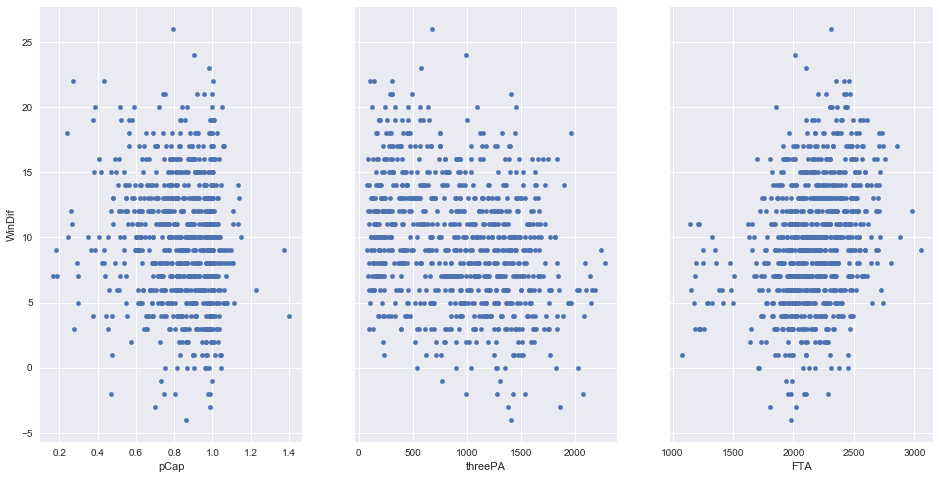

In [124]:
# visualize the relationship between the features and the response using scatterplots
#possibly add trend lines?
fig, axs = plt.subplots(1, 3, sharey=True)
df_model.plot(kind='scatter', x='pCap', y='WinDif', ax=axs[0], figsize=(16, 8))
df_model.plot(kind='scatter', x='threePA', y='WinDif', ax=axs[1])
df_model.plot(kind='scatter', x='FTA', y='WinDif', ax=axs[2])

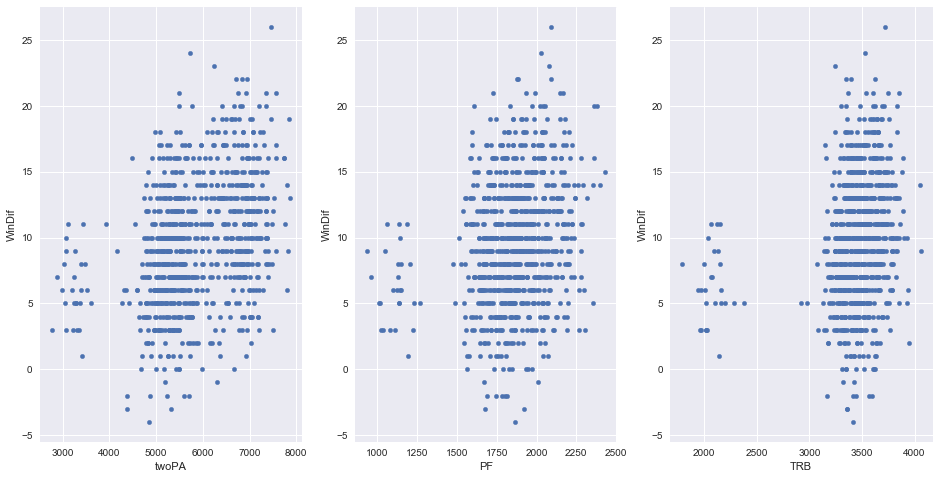

In [184]:
# visualize the relationship between the features and the response using scatterplots
#possibly add trend lines?
fig, axs = plt.subplots(1, 3, sharey=False)
df_model.plot(kind='scatter', x='twoPA', y='WinDif', ax=axs[0], figsize=(16, 8))
df_model.plot(kind='scatter', x='PF', y='WinDif', ax=axs[1])
df_model.plot(kind='scatter', x='TRB', y='WinDif', ax=axs[2])

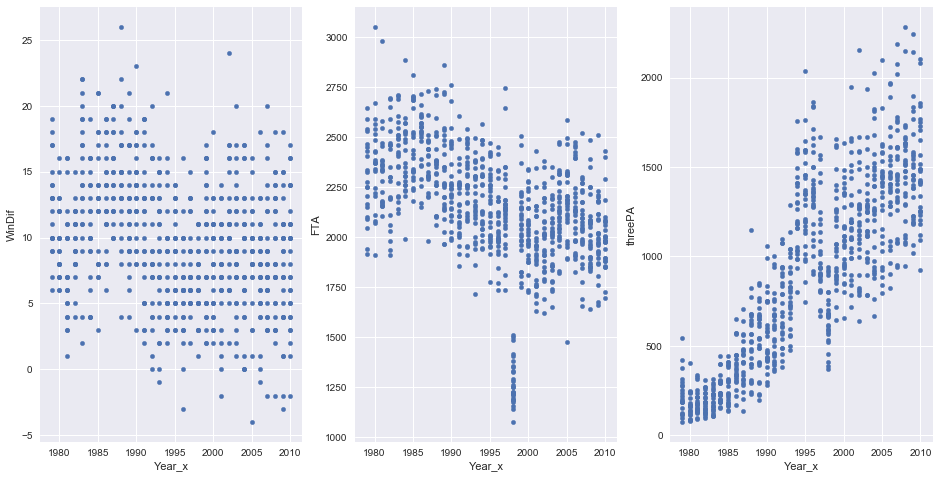

In [156]:
# visualize how the number of Free Throws and 3 Pointers a team takes per season has changed over time.
#Also visualize how homecourt advantage has changed over time
#Note - the 1997-1998 season was shortened due to a lockout which is why there is a massive dip in totals.
#possibly add trend lines?
fig, axs = plt.subplots(1, 3, sharey=False)
df_model.plot(kind='scatter', x='Year_x', y='WinDif', ax=axs[0], figsize=(16, 8))
df_model.plot(kind='scatter', x='Year_x', y='FTA', ax=axs[1])
df_model.plot(kind='scatter', x='Year_x', y='threePA', ax=axs[2])


In [174]:
#Use Random Forest to confirm what features from my data would be the most important/impactful.  I played around with a variety of features
#and settled on the ones you see below
from sklearn.ensemble import RandomForestClassifier
predictors = ['threePA', 'pCap', 'timezone_Eastern', 'timezone_Pacific', 'timezone_Mountain', 'FTA', 'elevtion']
X = df_model[['threePA', 'pCap', 'timezone_Eastern', 'timezone_Pacific', 'timezone_Mountain', 'FTA', 'elevation']]
y= df_model['WinDif']
model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [175]:
features = predictors
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head(10)

,Features,Importance Score
7,PF,0.241320
5,FTA,0.236607
0,threePA,0.233672
1,pCap,0.229800
2,timezone_Eastern,0.024122
3,timezone_Pacific,0.017453
4,timezone_Mountain,0.009890
6,elevtion,0.007137


In [185]:
# create a fitted model in one line
#formula notiation is the equivalent to writting out our models such that 'outcome = predictor'
#with the follwing syntax formula = 'outcome ~ predictor1 + predictor2 ... predictorN'
linmod = smf.ols(formula='WinDif ~ threePA + pCap + timezone_Eastern + timezone_Pacific + timezone_Mountain + FTA + elevation', data=df_model).fit()

#print the full summary
linmod.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 WinDif   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     21.64
Date:                Thu, 04 May 2017   Prob (F-statistic):           6.75e-27
Time:                        17:39:44   Log-Likelihood:                -2402.5
No. Observations:                 828   AIC:                             4821.
Df Residuals:                     820   BIC:                             4859.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             3.1323      1.593      1.966      0.050         0.005     6.259
threePA              -0.0020      0.000     -5.539      0.000        -0.003    -0.001
pCap                  0.2995      0.982      0.305      0.760        -1.627     2.226
timezone_Eastern      0.1012      0.390      0.260      0.795        -0.664     0.866
timezone_Pacific      0.1925      0.471      0.409      0.683        -0.732     1.117
timezone_Mountain     1.6232      0.844      1.924      0.055        -0.033     3.279
FTA                   0.0036      0.001      6.038      0.000         0.002     0.005
elevation             0.6951      0.964      0.721      0.471        -1.197     2.588
==============================================================================
Omnibus:                        2.740   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                2.790
Skew:                           0.138   Prob(JB):                        0.248
Kurtosis:                       2.934   Cond. No.                     2.57e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [128]:
linmod.params

Intercept            3.132275
threePA             -0.001957
pCap                 0.299528
timezone_Eastern     0.101225
timezone_Pacific     0.192480
timezone_Mountain    1.623248
FTA                  0.003577
elevation            0.695084
dtype: float64

In [170]:
# I removed the features I wasn't using so I could look at a correlation table
modeldata = df_model[['WinDif', 'PCTdif', 'threePA', 'pCap', 'timezone_Eastern', 'timezone_Pacific', 'timezone_Mountain', 'FTA', 'elevation']]
y = df_model.WinDif

In [173]:
modeldata.corr()

,WinDif,PCTdif,threePA,pCap,timezone_Eastern,timezone_Pacific,timezone_Mountain,FTA,elevation
WinDif,1.000000,0.986871,-0.299413,-0.106952,-0.053323,-0.009127,0.179806,0.317834,0.177663
PCTdif,0.986871,1.000000,-0.313039,-0.102918,-0.054045,-0.008744,0.179929,0.234678,0.179958
threePA,-0.299413,-0.313039,1.000000,0.435312,0.008804,0.014688,-0.059391,-0.386442,-0.087162
pCap,-0.106952,-0.102918,0.435312,1.000000,-0.151420,0.023177,0.075950,-0.156410,0.019102
timezone_Eastern,-0.053323,-0.054045,0.008804,-0.151420,1.000000,-0.433706,-0.324703,-0.038377,-0.259508
timezone_Pacific,-0.009127,-0.008744,0.014688,0.023177,-0.433706,1.000000,-0.175174,0.032561,-0.140001
timezone_Mountain,0.179806,0.179929,-0.059391,0.075950,-0.324703,-0.175174,1.000000,0.155297,0.799214
FTA,0.317834,0.234678,-0.386442,-0.156410,-0.038377,0.032561,0.155297,1.000000,0.180328
elevation,0.177663,0.179958,-0.087162,0.019102,-0.259508,-0.140001,0.799214,0.180328,1.000000


In [176]:
from sklearn import cross_validation
from sklearn import linear_model, metrics
kf = cross_validation.KFold(len(modeldata), n_folds=20, shuffle=True)

In [177]:
# This was where I was having a little trouble.  I wanted to use cross validation to evaluate my model but the results don't look
# right to me.  R squared is 1.0 in all of the folds and the MSE seems out of scale.  Am I missing something?
mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = linear_model.LinearRegression().fit(modeldata.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(modeldata.iloc[test_index])))
    scores.append(lm.score(modeldata, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 1.38636904152e-25
R2: 1.0
Model 2
MSE: 4.00147862889e-26
R2: 1.0
Model 3
MSE: 6.66159930475e-26
R2: 1.0
Model 4
MSE: 1.1956709721e-25
R2: 1.0
Model 5
MSE: 6.65955906628e-26
R2: 1.0
Model 6
MSE: 7.04032391238e-26
R2: 1.0
Model 7
MSE: 6.98890288776e-26
R2: 1.0
Model 8
MSE: 3.55313000297e-26
R2: 1.0
Model 9
MSE: 6.45116210312e-26
R2: 1.0
Model 10
MSE: 2.5895949923e-25
R2: 1.0
Model 11
MSE: 1.5880684247e-26
R2: 1.0
Model 12
MSE: 5.97993796544e-26
R2: 1.0
Model 13
MSE: 2.91374439076e-26
R2: 1.0
Model 14
MSE: 4.08757802093e-26
R2: 1.0
Model 15
MSE: 3.16765802267e-26
R2: 1.0
Model 16
MSE: 7.10099273219e-26
R2: 1.0
Model 17
MSE: 5.90135346991e-26
R2: 1.0
Model 18
MSE: 2.74375145464e-26
R2: 1.0
Model 19
MSE: 9.43772467382e-26
R2: 1.0
Model 20
MSE: 5.24647476683e-26
R2: 1.0
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 7.06198949436e-26
Mean of R2 for all folds: 1.0
